In [1]:
import numpy as np
import quantum_stuff as qs
import matplotlib.pyplot as plt
from tqdm import tqdm
import scienceplots
import sklearn.linear_model as LM
from scipy.special import comb
import nolds

plt.style.use(['science', 'no-latex'])

sx = qs.sigmax()
sy = qs.sigmay()
sz = qs.sigmaz()
I = np.eye(2)
xx = np.kron(sx, sx)
yy = np.kron(sy,sy)
zz = np.kron(sz,sz)

In [2]:
def encoding(uk):
    op = np.einsum('i, jk -> ijk', (1-2*uk), qs.sigmaz())
    return 0.5*(I+op)

In [341]:
Nq = 5
Js = 1
δt = 10/(Js)

wo = 1000
train_size = 10000
test_size = 10000
dim = wo + train_size + test_size
Z = qs.local_operators(sz, Nq)
X = qs.local_operators(sx, Nq)

In [342]:
sk = qs.MackeyGlass(steps = dim + 200)[217:]
ρ = qs.FNencoding(sk, basis = 'z', dm = True)

In [5]:
Δ = 1
Δ2 = 0
W = Δ2*Js
J = qs.random_coupling(Js, Nq)
D = np.random.uniform(-W, W, size = Nq)
h = Δ*Js

In [ ]:
H1 = qs.interaction(X, J) + np.dot((h + D),np.transpose(Z, (1, 0, 2)))

Memory Test

In [261]:
ρ_res = [qs.random_qubit(Nq-1, dm = True) for i in range(2)]

In [262]:
tstep = 1
outputs_traced = np.zeros((2, dim, 2**(Nq-1), 2**(Nq-1)), dtype = complex)
for i in tqdm(range(2)):
    outputs = qs.collisions(ρ, ρ_res[i], H1, δt, tstep)
    outputs_traced[i] = qs.ptrace(outputs, [k for k in range(1,Nq)])

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


In [263]:
dist = np.real(qs.distance(outputs_traced[0], outputs_traced[1]))

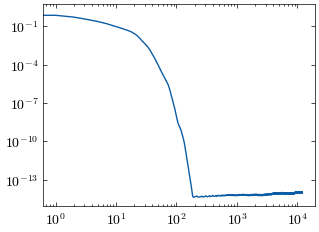

In [264]:
plt.loglog(dist)

In [265]:
x = np.zeros((dim, int(3*Nq + 3*comb(Nq, 2))))

In [266]:
ρ_wo = ρ[:wo]
ρ_train = ρ[wo:wo + train_size]
output = qs.collisions(ρ_wo, ρ_res[0], H1, δt, tstep)
ρ_res = qs.ptrace(output[-1], list(range(1, Nq)))
output_train = qs.collisions(ρ_train, ρ_res, H1, δt, tstep)
ρ_res_test = qs.ptrace(output_train[-1], list(range(1, Nq)))

In [312]:
x = np.hstack((qs.local_measurements(output_train), qs.two_qubits_measurements(output_train, [xx, yy, zz]), np.ones((train_size, 1))))
alpha = np.logspace(-9,3,1000)
ridge = LM.RidgeCV(alphas = alpha)
y_target = sk[wo+1:wo+train_size+1]
ridge.fit((x), y_target)


RidgeCV(alphas=array([1.00000000e-09, 1.02804473e-09, 1.05687597e-09, 1.08651577e-09,
       1.11698682e-09, 1.14831241e-09, 1.18051653e-09, 1.21362380e-09,
       1.24765955e-09, 1.28264983e-09, 1.31862140e-09, 1.35560179e-09,
       1.39361927e-09, 1.43270295e-09, 1.47288272e-09, 1.51418933e-09,
       1.55665436e-09, 1.60031031e-09, 1.64519059e-09, 1.69132952e-09,
       1.73876240e-09, 1.78752553e-0...
       5.29326606e+02, 5.44171429e+02, 5.59432571e+02, 5.75121707e+02,
       5.91250841e+02, 6.07832313e+02, 6.24878807e+02, 6.42403366e+02,
       6.60419396e+02, 6.78940681e+02, 6.97981391e+02, 7.17556092e+02,
       7.37679760e+02, 7.58367791e+02, 7.79636013e+02, 8.01500696e+02,
       8.23978568e+02, 8.47086827e+02, 8.70843150e+02, 8.95265713e+02,
       9.20373200e+02, 9.46184819e+02, 9.72720319e+02, 1.00000000e+03]))

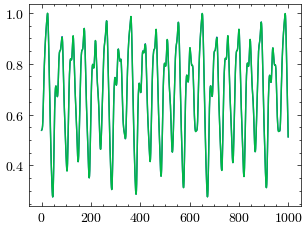

In [313]:
plt.plot(range(train_size),sk[wo+1:wo+train_size+1], range(train_size), grid_search.predict(x))

In [315]:
ρ_in = ρ[wo + train_size][np.newaxis]
ρ_res_test = qs.ptrace(output_train[-1], list(range(1, Nq)))
y_pred = np.zeros(test_size)
x_test = []
for i in range(200):
    output_test = qs.collisions(ρ_in, ρ_res_test, H1, δt, tstep)
    ρ_res_test = qs.ptrace(output_test[0], list(range(1,Nq)))
    x_test.append(np.hstack((qs.local_measurements(output_test), qs.two_qubits_measurements(output_test, [xx, yy, zz]), np.ones((1, 1)))))
    y_pred[i] = ridge.predict(x_test[i])
    if y_pred[i] < 0:
        y_pred[i] = 0
    ρ_in = qs.FNencoding(y_pred[np.newaxis, i], basis = 'z', dm = True)

C:\Users\marco\AppData\Local\Temp\ipykernel_13272\413901852.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\413901852.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\413901852.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\413901852.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is d

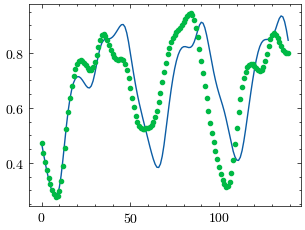

In [316]:
plt.plot(range(test_size)[:140], sk[wo + train_size+1:][:140], range(test_size)[:140], y_pred[:140], '.')

Ensemble test

In [5]:
ensemble = 10
Δ = 1
Δ2 = 0
W = Δ2*Js
J = [qs.random_coupling(Js, Nq) for i in range(ensemble)]
D = [np.random.uniform(-W, W, size = Nq) for i in range(ensemble)]
h = Δ*Js

In [6]:
Z = qs.local_operators(sz, Nq)
Y = qs.local_operators(sy, Nq)
X = qs.local_operators(sx, Nq)

In [7]:
H = [qs.interaction(X, J[i]) + np.dot((h + D[i]),np.transpose(Z, (1, 0, 2))) for i in range(ensemble)]

In [317]:
ρ_res = qs.random_qubit(Nq-1, dm = True)

In [318]:
tstep = 1
outputs_train = np.array([qs.collisions(ρ[:wo+train_size], ρ_res, H[i], δt, tstep)[-train_size:] for i in tqdm(range(ensemble))])

100%|██████████| 10/10 [00:00<00:00, 10.87it/s]


In [319]:
outputs_train.shape

(10, 1000, 32, 32)

In [320]:
x = np.array([np.hstack((qs.local_measurements(outputs_train[i]), qs.two_qubits_measurements(outputs_train[i], [xx, yy, zz]), np.ones((train_size, 1)))) for i in range(ensemble)])

In [322]:
alpha = np.logspace(-9,3, 1000)
ridge = [LM.RidgeCV(alphas = alpha) for i in range(ensemble)]
y_target = sk[wo+1:wo+train_size+1]
for i in tqdm(range(ensemble)):
    ridge[i].fit(x[i], y_target)

100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


In [323]:
y_pred_ens = []
for j in range(ensemble):
    ρ_in = ρ[wo + train_size][np.newaxis]
    ρ_res_test = qs.ptrace(outputs_train[j][-1], list(range(1, Nq)))
    y_pred = np.zeros(test_size)
    for i in range(200):
        output_test = qs.collisions(ρ_in, ρ_res_test, H[j], δt, tstep)
        ρ_res_test = qs.ptrace(output_test[0], list(range(1,Nq)))
        x_test = np.hstack((qs.local_measurements(output_test[0]), qs.two_qubits_measurements(output_test[0], [xx, yy, zz]), np.ones((1, 1))))
        y_pred[i] = ridge[j].predict(x_test)
        if y_pred[i] < 0:
            y_pred[i] = 0
        ρ_in = qs.FNencoding(y_pred[np.newaxis, i], basis = 'z', dm = True)
    y_pred_ens.append(y_pred)

C:\Users\marco\AppData\Local\Temp\ipykernel_13272\3152018436.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\3152018436.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\3152018436.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\3152018436.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a sca

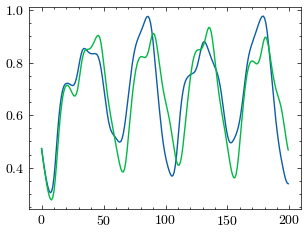

In [326]:
plt.plot(range(200), y_pred_ens[1][:200], range(200), sk[wo+train_size+1:wo+train_size+201])

Lyapunov Exponents - not sure about this part of the code

In [343]:
outputs = np.array([qs.collisions(ρ, ρ_res, H[i], δt, tstep) for i in tqdm(range(ensemble))])

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


In [102]:
np.save('lyap.npy',lyap)
np.save('y_pred.npy', y_pred)
np.save('sk.npy', sk)

In [344]:
x_lyap = np.array([np.hstack((qs.local_measurements(outputs[i][wo:]), qs.two_qubits_measurements(outputs[i][wo:], [xx, yy, zz]), np.ones((dim-wo, 1)))) for i in range(ensemble)])

In [348]:
lyap_r = [[nolds.lyap_r(x_lyap[i].T[j][:10000], emb_dim = 15) for j in tqdm(range(45))] for i in range(ensemble)]

  0%|          | 0/45 [00:00<?, ?it/s]c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\nolds\measures.py:253: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\nolds\measures.py:282: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 355
  7%|▋         | 3/45 [00:21<05:52,  8.40s/it]c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\nolds\measures.py:253: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\nolds\measures.py:282: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 355
  9%|▉         | 4/45 [00:23<03:48,  5.58s/it]c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\nolds\measures.py:253: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
c

KeyboardInterrupt: 

In [100]:
lyap = [[nolds.lyap_e(x_lyap[i].T[j], emb_dim = 46, matrix_dim = 4, min_nb = 30) for j in tqdm(range(45))] for i in range(ensemble)]

100%|██████████| 45/45 [19:31<00:00, 26.02s/it]


In [132]:
from sklearn.metrics import mean_squared_error as MSE

mse = [MSE(y_pred_ens[i][:200], sk[wo+train_size:wo+train_size+200]) for i in range(ensemble)]

In [137]:
lyap_pos = np.array(lyap)>0

In [ ]:
lyap_mean = np.mean(lyap, axis = (1))

In [159]:
ax1[0]

<Axes: >

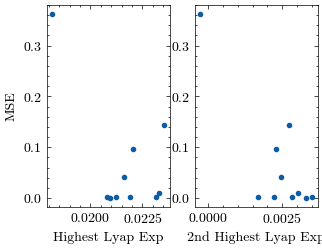

In [180]:
fig, ax1 = plt.subplots(ncols = 2)
ax1[0].set_xlabel('Highest Lyap Exp')
ax1[1].set_xlabel('2nd Highest Lyap Exp')
ax1[0].set_ylabel('MSE')
ax1[0].plot(lyap_mean[:,0], mse,'.')
ax1[1].plot(lyap_mean[:,1], mse,'.')

In [181]:
x_lyap.shape

(10, 9000, 46)

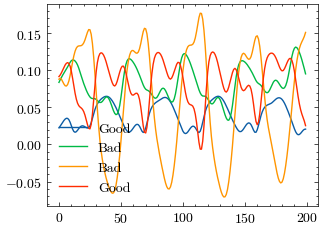

In [206]:
plt.plot(range(200), x_lyap[7].T[5][2000:2200], range(200), x_lyap[8].T[5][2000:2200], range(200), x_lyap[2].T[5][2000:2200], range(200),x_lyap[5].T[5][2000:2200])
plt.legend(['Good', 'Bad', 'Bad', 'Good'])

In [211]:
x_lyap.shape

(10, 9000, 46)

In [210]:
lyap_r = [[nolds.lyap_r(x_lyap[i].T[j], emb_dim = 46) for j in tqdm(range(45))] for i in range(ensemble)]

  0%|          | 0/45 [00:00<?, ?it/s]c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\nolds\measures.py:253: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2250
c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\nolds\measures.py:282: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 100
c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\nolds\measures.py:291: RuntimeWarning: for emb_dim = 46, lag = 100, min_tsep = 2250 and trajectory_len = 20 you need at least 9021 datapoints in your time series
  0%|          | 0/45 [00:05<?, ?it/s]


ValueError: Not enough data points. At least 4502 trajectories are required to find a valid neighbor for each orbit vector with min_tsep=2250 but only 4481 could be created.

In [174]:
np.max(lyap,1)[:,1]

array([0.00761423, 0.01010197, 0.01054683, 0.01070899, 0.01077226,
       0.00955106, 0.0092565 , 0.010734  , 0.00556225, 0.00798423])